In [95]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sklearn as sk

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mutual_info_score
from sklearn import preprocessing

from sklearn.metrics import accuracy_score

In [2]:
data_path = Path("Data/AB_NYC_2019.csv")
full_data_path = Path.cwd().parents[1].joinpath(data_path)
df = pd.read_csv(full_data_path)

In [3]:
base = ['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [4]:
df = df[base]

In [32]:
df.isna().sum()

neighbourhood_group               0
room_type                         0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [5]:
df.fillna(0, inplace=True)

In [6]:
df.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

### Question 1
What is the most frequent observation (mode) for the column 'neighbourhood_group'?
#### Answer
- Manhattan


### Split the data
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value ('price') is not in your dataframe.

In [7]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=11)

y_train = df_train.price.values
y_val = df_val.price.values

del df_train['price']
del df_val['price']

### Question 2
- Create the correlation matrix for the numerical features of your train dataset.
- In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
- What are the two features that have the biggest correlation in this dataset?

#### answer: number_of_reviews and reviews_per_month

In [8]:
corrMatrix = df.corr()
corrMatrix

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.018758,0.019517,-0.010983
longitude,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.138516,-0.114713,0.082731
price,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.050564,0.057472,0.081829
minimum_nights,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.124905,0.127960,0.144303
number_of_reviews,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.589407,-0.072376,0.172028
reviews_per_month,-0.018758,0.138516,-0.050564,-0.124905,0.589407,1.000000,-0.047312,0.163732
calculated_host_listings_count,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.047312,1.000000,0.225701
availability_365,-0.010983,0.082731,0.081829,0.144303,0.172028,0.163732,0.225701,1.000000


In [9]:
df.head(1)

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365


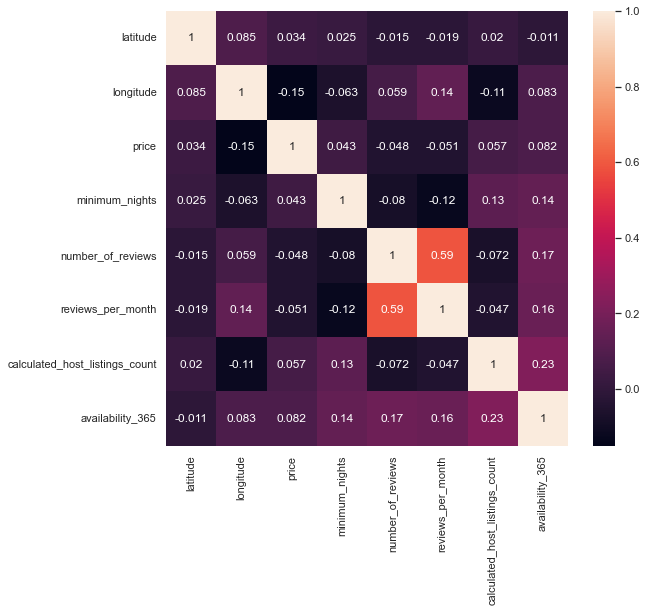

In [10]:
plt.figure(figsize=(9,8))
sns.heatmap(corrMatrix, annot=True, )
plt.show()

### Make price binary
- We need to turn the price variable from numeric into binary.
- Let's create a variable above_average which is 1 if the price is above (or equal to) 152.

### Question 3
- Calculate the mutual information score with the (binarized) price for the two categorical variables that we have. Use the training set only.
- Which of these two variables has bigger score?
- Round it to 2 decimal digits using round(score, 2)

#### Answer: The room_type is more important than the neighborhood group for the binarized price

In [88]:
y_train_df = pd.DataFrame(y_train, columns=["price"])
y_val_df = pd.DataFrame(y_val, columns=["price"])

In [89]:
y_train_df['above_average'] = y_train_df['price'].apply(lambda x: 1 if x >= 152 else 0)
y_val_df['above_average'] = y_val_df['price'].apply(lambda x: 1 if x >= 152 else 0)

In [90]:
y_train_vals = y_train_df.above_average.values
y_val_vals = y_val_df.above_average.values

In [13]:
round(mutual_info_score(df_train["neighbourhood_group"], y_train_df.above_average), 2)

0.05

In [14]:
round(mutual_info_score(df_train["room_type"], y_train_df.above_average), 2)

0.14

### Question 4
- Now let's train a logistic regression
- Remember that we have two categorical variables in the data. Include them using one-hot encoding.
- Fit the model on the training dataset.
- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
- model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
- Calculate the accuracy on the validation dataset and rount it to 2 decimal digits.

In [77]:
categorical = ["neighbourhood_group", "room_type"]
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
             'calculated_host_listings_count', 'availability_365']

In [78]:
# scaler = preprocessing.StandardScaler().fit(df_train[numerical])
# X_scaled = scaler.transform(df_train[numerical])

In [79]:
# df_train_scaled = pd.DataFrame(X_scaled, columns=[numerical])

In [80]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [85]:
model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, max_iter=100)
model.fit(X_train, y_train_vals)

LogisticRegression(random_state=42, solver='liblinear')

In [99]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [105]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
round((churn == y_val_vals).mean(), 2)

0.79

In [123]:
allvar_accuracy = round(accuracy_score(y_val_vals, y_pred >= 0.5), 2)
allvar_accuracy

0.79

### Question 5
- We have 9 features: 7 numerical features and 2 categorical.
- Let's find the least useful one using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
- Which of following feature has the smallest difference?
    - neighbourhood_group
    - room_type
    - number_of_reviews
    - reviews_per_month
- note: the difference doesn't have to be positive
#### Answer: 
number of reviews was the smallest difference

In [131]:
def logistic_regression_feature_eliminator():
    
    def diff(li1, li2):
        return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
    
    categorical = ["neighbourhood_group", "room_type"]
    numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                 'calculated_host_listings_count', 'availability_365']
    
    variables_and_accuracies = {}
    
    #numerical exclusion
    for numerical_var in numerical:
        removed_numerical = []
        temp_list = []
        temp_list.append(numerical_var)
        removed_numerical = diff(temp_list, numerical)
        
        # train
        train_dict = df_train[categorical + removed_numerical].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        X_train = dv.transform(train_dict)
        
        model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, max_iter=100)
        model.fit(X_train, y_train_vals)
        
        val_dict = df_val[categorical + removed_numerical].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:, 1]
        
        accuracy = accuracy_score(y_val_vals, y_pred >= 0.5)
        
        variables_and_accuracies[numerical_var] = allvar_accuracy - accuracy
    
    #categorical exclusion
    for categorical_var in categorical:
        removed_categorical = []
        temp_list = []
        temp_list.append(categorical_var)
        removed_categorical = diff(temp_list, categorical)
        
        # train
        train_dict = df_train[removed_categorical + numerical].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        X_train = dv.transform(train_dict)
        
        model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, max_iter=100)
        model.fit(X_train, y_train_vals)
        
        val_dict = df_val[removed_categorical + numerical].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:, 1]
        
        accuracy = accuracy_score(y_val_vals, y_pred >= 0.5)
        
        variables_and_accuracies[categorical_var] = allvar_accuracy - accuracy

    return variables_and_accuracies
    
vars_acc = logistic_regression_feature_eliminator()
for k, v in vars_acc.items():
    print(k, v)

latitude 0.009580777096114601
longitude 0.009580777096114601
minimum_nights 0.0039570552147240035
number_of_reviews 0.0035736196319018365
reviews_per_month 0.004212678936605374
calculated_host_listings_count 0.004851738241308801
availability_365 0.011753578732106362
neighbourhood_group 0.04562372188139063
room_type 0.0599386503067485


### Question 6
- For this question, we'll see how to use a linear regression model from Scikit-Learn
- We'll need to use the original column 'price'. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model on the training data.
- This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
- Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.
- If there are multiple options, select the smallest alpha.

In [133]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=11)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)


del df_train['price']
del df_val['price']

In [137]:
reg = LinearRegression().fit(df_train[numerical], y_train)
reg.score(df_train[numerical], y_train)

0.14319329684585225

In [141]:
from sklearn.linear_model import Ridge
for alpha in [0, 0.01, 0.1, 1, 10]:
    clf = Ridge(alpha=alpha)
    clf.fit(df_train[numerical], y_train)
    score = clf.score(df_train[numerical], y_train)
    
    print(alpha,":\t", score)

0 :	 0.14319329684585091
0.01 :	 0.1431932938568381
0.1 :	 0.143192998811693
1 :	 0.143164339892079
10 :	 0.14097690741671964
